In [1]:
import pandas as pd
import numpy as np
import json
import csv
import matplotlib.pyplot as plt

import pandas as pd
import gzip

from scipy import sparse

# Reference: https://beckernick.github.io/music_recommender/

# Loading and processing data

In [2]:
# Read in tsv files. 
user_data = pd.read_table('usersha1-artmbid-artname-plays.tsv',
                          header = None, 
                          names = ['users', 'musicbrainz-artist-id', 'artist-name', 'plays'],
                          usecols = ['users', 'artist-name', 'plays'])
user_profiles = pd.read_table('usersha1-profile.tsv',
                          header = None,
                          names = ['users', 'gender', 'age', 'country', 'signup'],
                          usecols = ['users', 'country'])

In [3]:
# Remove artists with no plays. 
if user_data['artist-name'].isnull().sum() > 0:
    user_data = user_data.dropna(axis = 0, subset = ['artist-name'])

In [4]:
# Add column with sum of total artist plays.
artist_plays = (user_data.
     groupby(by = ['artist-name'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_artist_plays'})
     [['artist-name', 'total_artist_plays']]
    )

user_data_with_artist_plays = user_data.merge(artist_plays, left_on = 'artist-name', right_on = 'artist-name', how = 'left')

In [5]:
# Remove artists with less than popularity_threshold plays. 
popularity_threshold = 1000000

user_data_popular_artists = user_data_with_artist_plays.query('total_artist_plays >= @popularity_threshold')
combined = user_data_popular_artists.merge(user_profiles, left_on = 'users', right_on = 'users', how = 'left')

usa_data = combined.query('country == \'United States\'')

In [6]:
# Add column with sum of total user plays. 
user_plays = (usa_data.
     groupby(by = ['users'])['plays'].
     sum().
     reset_index().
     rename(columns = {'plays': 'total_user_plays'})
     [['users', 'total_user_plays']]
    )

plays_data = usa_data.merge(user_plays, left_on = 'users', right_on = 'users', how = 'left')

In [7]:
# Remove users with less than plays_threshold plays. 
plays_threshold = 1000

final_data = plays_data.query('total_user_plays >= @plays_threshold')

# Creating hypergraph

In [8]:
max_users = 100 # E. can go up to 480189.
max_artists = 500 # V. can go up to 17770

E = max_users
V = max_artists

# initializing to some values, will add rows/columns as seen fit 
W = np.zeros((V, E)) # hyperedge-weight matrix, |V|x |E|, each row corresponds to a movie. 
R = np.zeros((E, V)) # edge-dependent vertex-weight matrix, |E| x |V|, each row corresponds to a user.
true_R = np.zeros((E, V)) # same but without erasing.

num_pairs = 0
erase_prob = 0.15

In [9]:
curr_avail_user_index = 0
curr_avail_artist_index = 0
user_dict = {} 
artist_dict = {}

In [10]:
for _, row in final_data.iterrows():
    user = row['users']
    artist = row['artist-name']
    plays = int(row['plays'])
    
    user_index = user_dict.get(user)
    
    if user_index == None:
        if curr_avail_user_index < max_users:
            user_dict[user] = curr_avail_user_index
            user_index = curr_avail_user_index
            curr_avail_user_index += 1
        else:
            continue
    
    artist_index = artist_dict.get(artist)
    
    if artist_index == None:
        if curr_avail_artist_index < max_artists:
            artist_dict[artist] = curr_avail_artist_index
            artist_index = curr_avail_artist_index
            curr_avail_artist_index += 1
        else:
            continue
    
    
    
    true_R[user_index][artist_index] = plays
    
    err = np.random.rand(1)
    if err > erase_prob:
        W[artist_index][user_index] = 1
        R[user_index][artist_index] = plays
    
    num_pairs += 1

In [11]:
similarities = np.zeros((E, E))

for i in range(E):
    for j in range(i+1, E):
        for song in range(V):
            if R[i][song] != 0 and R[j][song] != 0:
                similarities[i][j] += 1
                similarities[j][i] += 1

In [12]:
# We want the nonzero rows of W and R to sum to 1 
def row_normalize(X):
    Y = np.matrix.copy(X)
    for i in range(len(Y)):
        row = Y[i]
        row_sum = np.sum(row)
        if row_sum != 0:
            Y[i] = Y[i]/row_sum   
    return Y

In [13]:
Rs = sparse.csr_matrix(row_normalize(R))
Ws = sparse.csr_matrix(row_normalize(W))
P = np.transpose(Ws.dot(Rs))

In [14]:
def get_Wi(user_index):
    Wi = np.copy(W)
    for other_user_index in range(len(similarities[user_index])):
        if other_user_index == user_index:
            continue
        similarity = similarities[user_index][other_user_index]
        Wi[:,other_user_index] *= (2 ** similarity)
        
    return Wi

In [15]:
def get_P_hg(Wi):

    Wis = sparse.csr_matrix(row_normalize(Wi))
    Pi = np.transpose(Wis.dot(Rs))
    
    return Pi

# Creating graph

In [16]:
def get_P_g(Wi):
    WiG = np.zeros((V+E, num_pairs)) 
    RG = np.zeros((num_pairs, V+E)) 

    curr_edge_index = 0 

    for i in range(V):
        for j in range(E):
            if R[j][i] != 0:
                    # movie index = i
                    # user index = V+j

                RG[curr_edge_index][V+j] = 1
                RG[curr_edge_index][i] = 1

                WiG[V+j][curr_edge_index] = Wi[i][j] * R[j][i]
                WiG[i][curr_edge_index] = WiG[V+j][curr_edge_index]

                curr_edge_index += 1
                
    WiGs = sparse.csr_matrix(row_normalize(WiG))
    RGs = sparse.csr_matrix(row_normalize(RG))
    PiG = np.transpose(WiGs.dot(RGs))
    
    return PiG

# Compute rankings

In [17]:
# given probability transition matrix P
# where P_{v,w} = Prob(w -> v)
# find pagerank scores with restart probability r
def compute_pr(P, r, n, home, eps=1e-8):
    
    x = np.ones(n) / n*1.0

    flag = True
    t=0
        
    while flag:
        x_new = (1-r)*P*x

        x_new = x_new + home * r 
        
        if np.linalg.norm(x_new - x,ord=1) < eps and t > 100:
            flag = False
        t=t+1
        x = x_new
    
    return x

In [18]:
def compute_rankings(user_index, Pi, PiG, r=0.15):
    # personalize the algorithm by restarting at any of the movies a certain user originally watched
    home_hg = np.zeros(V)

    for j in range(V):
        if R[user_index][j] != 0:
            home_hg[j] = 1

    if np.sum(home_hg) > 0:
        home_hg = home_hg / np.sum(home_hg)

        ranking_hg = compute_pr(Pi, r, V, home_hg).flatten()

        # same process for the graph
        home_g = np.zeros(V+E)
        home_g[V+user_index] = 1

        curr_rankings_g = compute_pr(PiG, r, V+E, home_g).flatten()
        ranking_g = curr_rankings_g[:V]
        
    return ranking_hg, ranking_g

# Evaluate rankings

In [19]:
# Source: https://www.aaai.org/Papers/IJCAI/2007/IJCAI07-444.pdf
def calc_doa(num_movies, given_rating, true_rating, ranking):
    
    total_pairs = 0
    correct_pairs = 0
    
    # All pairs of movies. 
    for i in range(num_movies):
        for j in range(i+1, num_movies):
            if given_rating[i] == 0 and true_rating[i] != 0 and given_rating[j] == 0 and true_rating[j] != 0:
                if true_rating[i] < true_rating[j]:
                    total_pairs += 1
                    if ranking[i] < ranking[j]:
                        correct_pairs += 1
                elif true_rating[i] > true_rating[j]:
                    total_pairs += 1
                    if ranking[i] > ranking[j]:
                        correct_pairs += 1
       
    if total_pairs == 0:
        return -1
    return correct_pairs/total_pairs

# Run thing

In [20]:
doa_dumb = 0
doa_hg = 0
doa_g = 0

count = 0

for i in range(E):
    Wi = get_Wi(i)
    Pi = get_P_hg(Wi)
    PiG = get_P_g(Wi)
    ranking_hg, ranking_g = compute_rankings(i, Pi, PiG)
    ranking_dumb, _ = compute_rankings(i, P, PiG)
    
    curr_doa_hg = calc_doa(V, R[i], true_R[i], ranking_hg)
    curr_doa_g = calc_doa(V, R[i], true_R[i], ranking_g)
    curr_doa_dumb = calc_doa(V, R[i], true_R[i], ranking_dumb)
    
    if curr_doa_dumb > 0 or curr_doa_hg > 0 or curr_doa_g > 0:
        doa_dumb += curr_doa_dumb
        doa_hg += curr_doa_hg
        doa_g += curr_doa_g
        count += 1
    
doa_hg /= count
doa_g /= count
doa_dumb /= count

In [21]:
print(doa_hg)
print(doa_g)
print(doa_dumb)

0.6096755368814193
0.6070144724556489
0.5361188920012451


In [23]:
count = [0 for _ in range(max_artists)]

for i in range(len(similarities)):
    for j in range(len(similarities[0])):
        index = similarities[i][j]
        count[int(index)] += 1

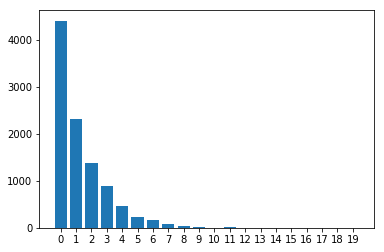

In [28]:
_ = plt.bar([i for i in range(20)], count[:20])
_ = plt.xticks(np.arange(0, 20, 1))

In [25]:
for i in range(max_users):
    print(true_R[i])

[456. 407. 386. 213. 203. 189. 184. 178. 162. 149. 144. 143. 121. 118.
 118. 117. 109. 106.  86.  86.  83.  74.  72.  71.  68.  67.  66.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 